<a href="https://colab.research.google.com/github/IbrahimAllMamun/flood_incidence/blob/main/flood_incidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library and Data

In [77]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, metrics, Input, Model
from tensorflow.keras.activations import gelu

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Random state initialization
RANDOM_STATE = 21
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

In [78]:
!wget https://raw.githubusercontent.com/IbrahimAllMamun/flood_incidence/main/flood.csv

--2025-09-19 12:19:35--  https://raw.githubusercontent.com/IbrahimAllMamun/flood_incidence/main/flood.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2071590 (2.0M) [text/plain]
Saving to: ‘flood.csv.3’

flood.csv.3         100%[===================>]   1.98M  6.00MB/s    in 0.3s    

2025-09-19 12:19:36 (6.00 MB/s) - ‘flood.csv.3’ saved [2071590/2071590]



In [79]:
df = pd.read_csv('flood.csv')
df.rename(columns={'Flood?':'Flood'}, inplace=True)
df = df.sort_values(["Year", "Month", "Station_Number"])
df.drop(columns=['Sl', 'LATITUDE', 'LONGITUDE', 'Period'], inplace=True)
df.fillna({'Flood':0}, inplace=True)
display(df.head())

,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,ALT,Flood
5892,Dinajpur,1948,1,28.9,10.4,0.000000,60.00000,0.624074,1.3,5.572000,41863,365790.2,834718.0,37,0.0
1356,Bogra,1948,1,25.8,11.7,8.140625,74.21875,0.875926,1.1,7.296226,41883,435303.7,751187.5,20,0.0
13188,Mymensingh,1948,1,28.3,11.7,0.000000,67.00000,0.594444,1.7,6.134286,41886,540975.3,737535.8,19,0.0
18288,Srimangal,1948,1,27.7,9.0,8.015385,75.00000,0.464815,2.4,6.710714,41915,675761.6,687095.9,23,0.0
6684,Faridpur,1948,1,27.8,11.9,3.000000,91.00000,0.746296,2.9,6.986207,41929,483877.3,610719.3,9,0.0


In [80]:
df.shape

(20544, 15)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20544 entries, 5892 to 20543
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Station_Names      20544 non-null  object 
 1   Year               20544 non-null  int64  
 2   Month              20544 non-null  int64  
 3   Max_Temp           20544 non-null  float64
 4   Min_Temp           20544 non-null  float64
 5   Rainfall           20544 non-null  float64
 6   Relative_Humidity  20544 non-null  float64
 7   Wind_Speed         20544 non-null  float64
 8   Cloud_Coverage     20544 non-null  float64
 9   Bright_Sunshine    20544 non-null  float64
 10  Station_Number     20544 non-null  int64  
 11  X_COR              20544 non-null  float64
 12  Y_COR              20544 non-null  float64
 13  ALT                20544 non-null  int64  
 14  Flood              20544 non-null  float64
dtypes: float64(10), int64(4), object(1)
memory usage: 2.5+ MB


# Data cleaning and sequence building

In [82]:
df["Month_sin"] = np.sin(2 * np.pi * (df["Month"] - 1) / 12.0)
df["Month_cos"] = np.cos(2 * np.pi * (df["Month"] - 1) / 12.0)

In [83]:
time_varying = [
    "Max_Temp", "Min_Temp", "Rainfall", "Relative_Humidity",
    "Wind_Speed", "Cloud_Coverage", "Bright_Sunshine",
    "Month_sin", "Month_cos"
]
static_feats = ["ALT", "X_COR", "Y_COR"]

In [84]:
def build_sequences_monthly(df, window=12):
    X_seq, X_static, y, groups = [], [], [], []

    for st, g in df.groupby("Station_Number"):
        g = g.sort_values(["Year", "Month"])   # continuous timeline per station

        seq_data = g[time_varying].to_numpy(dtype=float)
        static_vals = g[static_feats].iloc[0].to_numpy(dtype=float)
        labels = g["Flood"].to_numpy(dtype=int)
        years = g["Year"].to_numpy()
        months = g["Month"].to_numpy()

        for i in range(len(g) - window):
            X_seq.append(seq_data[i:i+window])
            X_static.append(static_vals)
            y.append(labels[i+window])  # predict flood in next month
            groups.append((st, years[i+window], months[i+window]))

    return (
        np.array(X_seq),
        np.array(X_static),
        np.array(y).astype(int),
        pd.DataFrame(groups, columns=["Station_Number", "Year", "Month"])
    )


# Example
X_seq, X_static, y, groups = build_sequences_monthly(df, window=12)
print("Sequences:", X_seq.shape)   # (N, 12, n_features)
print("Static:", X_static.shape)   # (N, 3)
print("Labels:", y.shape)          # (N,)
print("Positives:", y.sum(), "Negatives:", (y==0).sum())

Sequences: (20148, 12, 9)
Static: (20148, 3)
Labels: (20148,)
Positives: 4048 Negatives: 16100


In [85]:
groups

,Station_Number,Year,Month
0,41859,1955,1
1,41859,1955,2
2,41859,1955,3
3,41859,1955,4
4,41859,1955,5
...,...,...,...
20143,41998,2013,8
20144,41998,2013,9
20145,41998,2013,10
20146,41998,2013,11


## Data splitting

In [86]:
def scale_data(X_seq, X_sta):
    Ntr, T, F = X_seq.shape

    seq_scaler = StandardScaler()
    sta_scaler = StandardScaler()

    Xseq = seq_scaler.fit_transform(X_seq.reshape(-1, F)).reshape(Ntr, T, F)
    Xsta  = sta_scaler.fit_transform(X_sta)

    return Xseq, Xsta

# Build sequences first
X_seq, X_static, y, groups = build_sequences_monthly(df, window=12)

X_seq, X_static = scale_data(X_seq, X_static)

# Choose cutoff year
cutoff_year_val = 1995
cutoff_year_test = 2004

train_idx = groups["Year"] <= cutoff_year_val
val_idx = (groups["Year"] > cutoff_year_val) & (groups["Year"] < cutoff_year_test)

ftrain_idx = groups["Year"] <= cutoff_year_test
test_idx  = groups["Year"] > cutoff_year_test


fXseq_tr_s,     Xseq_tr_s,     Xseq_val_s,  Xseq_te_s   = X_seq[ftrain_idx],    X_seq[train_idx],     X_seq[val_idx] ,    X_seq[test_idx]
fXs_tr_s,       Xs_tr_s,       Xs_val_s,    Xs_te_s     = X_static[ftrain_idx], X_static[train_idx],  X_static[val_idx] , X_static[test_idx]
fy_train,       y_train,       y_val ,      y_test      = y[ftrain_idx],        y[train_idx],         y[val_idx] ,        y[test_idx]
fgroups_train,  groups_train,  groups_val,  groups_test = groups[ftrain_idx],   groups[train_idx],    groups[val_idx] ,   groups[test_idx]

print("Train:", Xseq_tr_s.shape, "Positives:", y_train.sum())
print("Validation :", Xseq_val_s.shape, "Positives:", y_val.sum())

print("Final Training :", fXseq_tr_s.shape, "Positives:", fy_train.sum())
print("Test :", Xseq_te_s.shape, "Positives:", y_test.sum())

Train: (13200, 12, 9) Positives: 2554
Validation : (3072, 12, 9) Positives: 656
Final Training : (16656, 12, 9) Positives: 3308
Test : (3492, 12, 9) Positives: 740


In [87]:
X_seq, X_static, y, groups = build_sequences_monthly(df, window=12)
print("Sequences:", Xseq_tr_s.shape)   # (N, 12, n_features)
print("Static:", Xs_tr_s.shape)   # (N, 3)

Sequences: (13200, 12, 9)
Static: (13200, 3)


# Model Building

## make_model() function

In [88]:
def make_model(n_steps, n_seq_feats, n_static_feats, lstm_units=(64, 32), dense_units=32, dropout=0.2, lr=1e-3, threshold=0.5):
    initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
    prelu_initializer = tf.keras.initializers.he_normal(seed=RANDOM_STATE)


    seq_in = Input(shape=(n_steps, n_seq_feats), name="seq_in")
    x = seq_in

    # GRU stack
    x = layers.GRU(lstm_units[0], return_sequences=True, dropout=dropout, recurrent_dropout=.5*dropout, kernel_initializer=initializer, name="GRU_1")(x)
    x = layers.GRU(lstm_units[1], dropout=dropout, recurrent_dropout=.5*dropout, kernel_initializer=initializer, name="GRU_2")(x)
    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_1")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_1")(x)
    x = layers.Dropout(dropout, name="Dropout_1")(x)

    inputs = [seq_in]

    sta_in = Input(shape=(n_static_feats,), name="static_in")
    s = layers.Dense(32, kernel_initializer=initializer, name="Static_Dense_1")(sta_in)
    s = layers.PReLU(alpha_initializer=prelu_initializer, name="Static_PReLU_1")(s)
    s = layers.Dropout(dropout, name="Static_Dropout_1")(s)
    x = layers.Concatenate()([x, s])
    inputs.append(sta_in)

    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_2")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_2")(x)
    x = layers.Dropout(dropout, name="Dropout_2")(x)
    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_3")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_3")(x)
    x = layers.Dropout(dropout, name="Dropout_3")(x)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)

    model_GRU = Model(inputs=inputs, outputs=out, name="GRU")
    model_GRU.compile(
        # optimizer=optimizers.SGD(learning_rate=lr) if optimizer=="SGD" else optimizers.Adam(learning_rate=lr),
        optimizer=optimizers.RMSprop(learning_rate=lr, rho=0.9),
        loss="binary_crossentropy",
        metrics=[
            metrics.AUC(curve="ROC", name="auc_roc"),
            metrics.AUC(curve="PR",  name="auc_pr"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.BinaryAccuracy(name="accuracy", threshold=threshold)
        ],
    )



    seq_in = Input(shape=(n_steps, n_seq_feats), name="seq_in")
    x = seq_in

    # LSTM stack
    x = layers.LSTM(lstm_units[0], return_sequences=True, dropout=dropout, recurrent_dropout=.5*dropout, kernel_initializer=initializer, name="LSTM_1")(x)
    x = layers.LSTM(lstm_units[1], dropout=dropout, recurrent_dropout=.5*dropout, kernel_initializer=initializer, name="LSTM_2")(x)
    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_1")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_1")(x)
    x = layers.Dropout(dropout, name="Dropout_1")(x)

    inputs = [seq_in]

    sta_in = Input(shape=(n_static_feats,), name="static_in")
    s = layers.Dense(32, kernel_initializer=initializer, name="Static_Dense_1")(sta_in)
    s = layers.PReLU(alpha_initializer=prelu_initializer, name="Static_PReLU_1")(s)
    s = layers.Dropout(dropout, name="Static_Dropout_1")(s)
    x = layers.Concatenate()([x, s])
    inputs.append(sta_in)

    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_2")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_2")(x)
    x = layers.Dropout(dropout, name="Dropout_2")(x)
    x = layers.Dense(dense_units, kernel_initializer=initializer, name="Dense_3")(x)
    x = layers.PReLU(alpha_initializer=prelu_initializer, name="PReLU_3")(x)
    x = layers.Dropout(dropout, name="Dropout_3")(x)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)

    model_LSTM = Model(inputs=inputs, outputs=out, name="LSTM")
    model_LSTM.compile(
        # optimizer=optimizers.SGD(learning_rate=lr) if optimizer=="SGD" else optimizers.Adam(learning_rate=lr),
        optimizer=optimizers.RMSprop(learning_rate=lr, rho=0.9),
        loss="binary_crossentropy",
        metrics=[
            metrics.AUC(curve="ROC", name="auc_roc"),
            metrics.AUC(curve="PR",  name="auc_pr"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.BinaryAccuracy(name="accuracy", threshold=threshold)
        ],
    )

    return model_GRU, model_LSTM

## Model call

In [89]:
Ntr, T, F = Xseq_tr_s.shape
model_GRU, model_LSTM = make_model(
              n_steps=T,
              n_seq_feats=F,
              n_static_feats=Xs_tr_s.shape[1],
              lstm_units=(128, 64),
              dense_units=64,
              dropout=0.3,
              lr=1e-3,
              threshold=0.5
            )

model_GRU.summary()
model_LSTM.summary()

Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 12, 9)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_1 (GRU)         │ (None, 12, 128)   │     53,376 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_2 (GRU)         │ (None, 64)        │     37,248 │ GRU_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_in           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_1 (Dense)     │ (None, 64)        │      4,160 │ GRU_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_Dense_1      │ (None, 32)        │        128 │ static_in[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_1 (PReLU)     │ (None, 64)        │         64 │ Dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_PReLU_1      │ (None, 32)        │         32 │ Static_Dense_1[0… │
│ (PReLU)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 64)        │          0 │ PReLU_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_Dropout_1    │ (None, 32)        │          0 │ Static_PReLU_1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 96)        │          0 │ Dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ Static_Dropout_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_2 (Dense)     │ (None, 64)        │      6,208 │ concatenate_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_2 (PReLU)     │ (None, 64)        │         64 │ Dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_2 (Dropout) │ (None, 64)        │          0 │ PReLU_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_3 (Dense)     │ (None, 64)        │      4,160 │ Dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_3 (PReLU)     │ (None, 64)        │         64 │ Dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_3 (Dropout) │ (None, 64)        │          0 │ PReLU_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ Dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,569 (412.38 KB)

 Trainable params: 105,569 (412.38 KB)

 Non-trainable params: 0 (0.00 B)

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 12, 9)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_1 (LSTM)       │ (None, 12, 128)   │     70,656 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_2 (LSTM)       │ (None, 64)        │     49,408 │ LSTM_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_in           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_1 (Dense)     │ (None, 64)        │      4,160 │ LSTM_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_Dense_1      │ (None, 32)        │        128 │ static_in[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_1 (PReLU)     │ (None, 64)        │         64 │ Dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_PReLU_1      │ (None, 32)        │         32 │ Static_Dense_1[0… │
│ (PReLU)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 64)        │          0 │ PReLU_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_Dropout_1    │ (None, 32)        │          0 │ Static_PReLU_1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 96)        │          0 │ Dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ Static_Dropout_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_2 (Dense)     │ (None, 64)        │      6,208 │ concatenate_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_2 (PReLU)     │ (None, 64)        │         64 │ Dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_2 (Dropout) │ (None, 64)        │          0 │ PReLU_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_3 (Dense)     │ (None, 64)        │      4,160 │ Dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PReLU_3 (PReLU)     │ (None, 64)        │         64 │ Dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_3 (Dropout) │ (None, 64)        │          0 │ PReLU_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ Dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 135,009 (527.38 KB)

 Trainable params: 135,009 (527.38 KB)

 Non-trainable params: 0 (0.00 B)

## Training Models

In [90]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
pos_weight = neg / max(pos, 1)
class_weight = {0: 1.0, 1: float(pos_weight)}
print("Class weights:", class_weight)

es = callbacks.EarlyStopping(
    monitor="val_auc_pr", # Changed monitor to val_accuracy
    mode="max",
    patience=10,
    restore_best_weights=True
)

Class weights: {0: 1.0, 1: 4.168363351605325}


### GRU-RNN

In [91]:
history_GRU = model_GRU.fit(
    x=[Xseq_tr_s, Xs_tr_s],
    y=y_train,
    validation_data=([Xseq_val_s, Xs_val_s], y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)

Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.7185 - auc_pr: 0.5343 - auc_roc: 0.8487 - loss: 0.7602 - precision: 0.4128 - recall: 0.8857 - val_accuracy: 0.8275 - val_auc_pr: 0.7676 - val_auc_roc: 0.9207 - val_loss: 0.3234 - val_precision: 0.5665 - val_recall: 0.8186
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.7873 - auc_pr: 0.6436 - auc_roc: 0.9020 - loss: 0.6151 - precision: 0.4799 - recall: 0.9012 - val_accuracy: 0.8138 - val_auc_pr: 0.7626 - val_auc_roc: 0.9193 - val_loss: 0.3399 - val_precision: 0.5405 - val_recall: 0.8537
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.7848 - auc_pr: 0.6582 - auc_roc: 0.9022 - loss: 0.6190 - precision: 0.4765 - recall: 0.8962 - val_accuracy: 0.8206 - val_auc_pr: 0.7719 - val_auc_roc: 0.9221 - val_loss: 0.3250 - val_precision: 0.5513 - val_recall: 0.8598
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.7897 - auc_pr: 0.6828 - auc_roc: 0.9101 - loss: 0.5937 - p

#### Threshold tuning on validation

In [92]:
val_probs = model_GRU.predict([Xseq_val_s, Xs_val_s]).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_probs)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best threshold (F1 on val):", best_thr)



96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Best threshold (F1 on val): 0.66333044


#### Final evaluation on test

In [93]:
from sklearn.metrics import accuracy_score


test_probs = model_GRU.predict([Xseq_te_s, Xs_te_s]).ravel()
test_pred  = (test_probs >= best_thr).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC:",  average_precision_score(y_test, test_probs))
print("Accuracy:", accuracy_score(y_test, test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
ROC-AUC: 0.9095385174418604
PR-AUC: 0.7309044205680837
Accuracy: 0.8516609392898052
Confusion matrix:
 [[2483  269]
 [ 249  491]]
              precision    recall  f1-score   support

           0      0.909     0.902     0.906      2752
           1      0.646     0.664     0.655       740

    accuracy                          0.852      3492
   macro avg      0.777     0.783     0.780      3492
weighted avg      0.853     0.852     0.852      3492



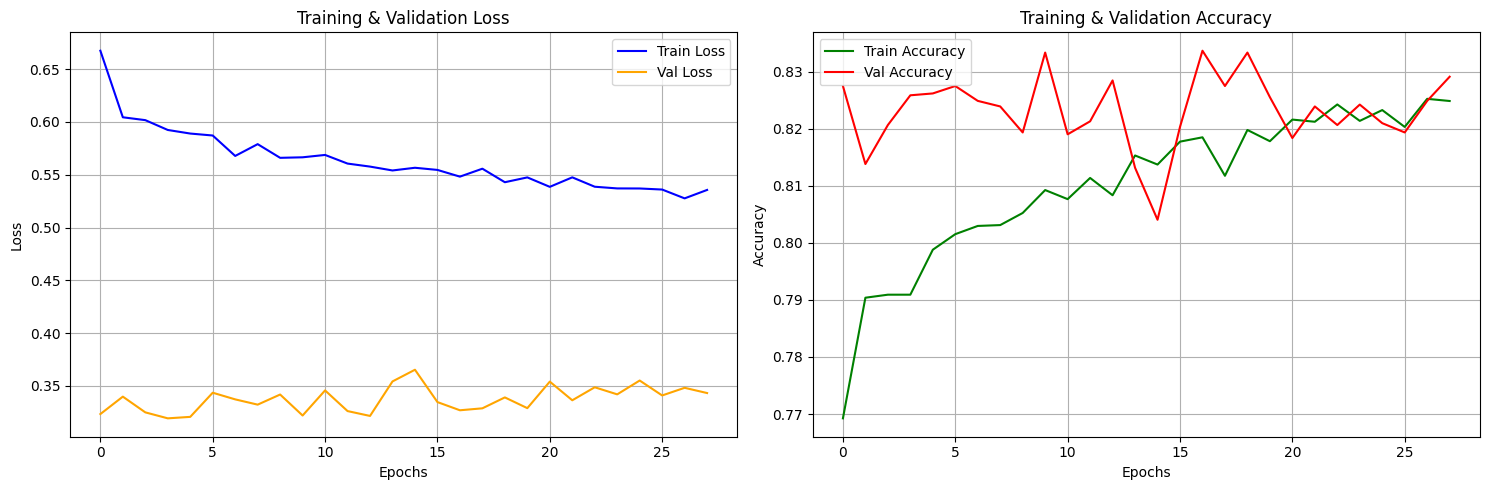

In [94]:
# -----------------------
# 9) Plot Training Curves
# -----------------------
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# --------- Loss subplot ---------
axs[0].plot(history_GRU.history["loss"], label="Train Loss", color='blue')
axs[0].plot(history_GRU.history["val_loss"], label="Val Loss", color='orange')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training & Validation Loss")
axs[0].legend()
axs[0].grid(True)

# --------- Accuracy subplot (if exists) ---------
axs[1].plot(history_GRU.history["accuracy"], label="Train Accuracy", color='green')
axs[1].plot(history_GRU.history["val_accuracy"], label="Val Accuracy", color='red')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training & Validation Accuracy")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### LSTM-RNN

In [95]:
history_LSTM = model_LSTM.fit(
    x=[Xseq_tr_s, Xs_tr_s],
    y=y_train,
    validation_data=([Xseq_val_s, Xs_val_s], y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)

Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.6987 - auc_pr: 0.5324 - auc_roc: 0.8396 - loss: 0.7830 - precision: 0.3977 - recall: 0.8875 - val_accuracy: 0.8203 - val_auc_pr: 0.7581 - val_auc_roc: 0.9172 - val_loss: 0.3421 - val_precision: 0.5523 - val_recall: 0.8369
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.7873 - auc_pr: 0.6532 - auc_roc: 0.9010 - loss: 0.6312 - precision: 0.4796 - recall: 0.8875 - val_accuracy: 0.8206 - val_auc_pr: 0.7725 - val_auc_roc: 0.9220 - val_loss: 0.3480 - val_precision: 0.5496 - val_recall: 0.8872
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.7969 - auc_pr: 0.6686 - auc_roc: 0.9069 - loss: 0.6125 - precision: 0.4926 - recall: 0.9014 - val_accuracy: 0.8213 - val_auc_pr: 0.7730 - val_auc_roc: 0.9215 - val_loss: 0.3283 - val_precision: 0.5530 - val_recall: 0.8506
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.7895 - auc_pr: 0.6714 - auc_roc: 0.9101 - loss: 0.5951 - p

#### Threshold tuning on validation

In [96]:
val_probs = model_LSTM.predict([Xseq_val_s, Xs_val_s]).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_probs)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best threshold (F1 on val):", best_thr)



96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Best threshold (F1 on val): 0.6720027


#### Final evaluation on test

In [97]:
from sklearn.metrics import accuracy_score


test_probs = model_LSTM.predict([Xseq_te_s, Xs_te_s]).ravel()
test_pred  = (test_probs >= best_thr).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC:",  average_precision_score(y_test, test_probs))
print("Accuracy:", accuracy_score(y_test, test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
ROC-AUC: 0.9110872682275298
PR-AUC: 0.7319817384399148
Accuracy: 0.8562428407789232
Confusion matrix:
 [[2480  272]
 [ 230  510]]
              precision    recall  f1-score   support

           0      0.915     0.901     0.908      2752
           1      0.652     0.689     0.670       740

    accuracy                          0.856      3492
   macro avg      0.784     0.795     0.789      3492
weighted avg      0.859     0.856     0.858      3492



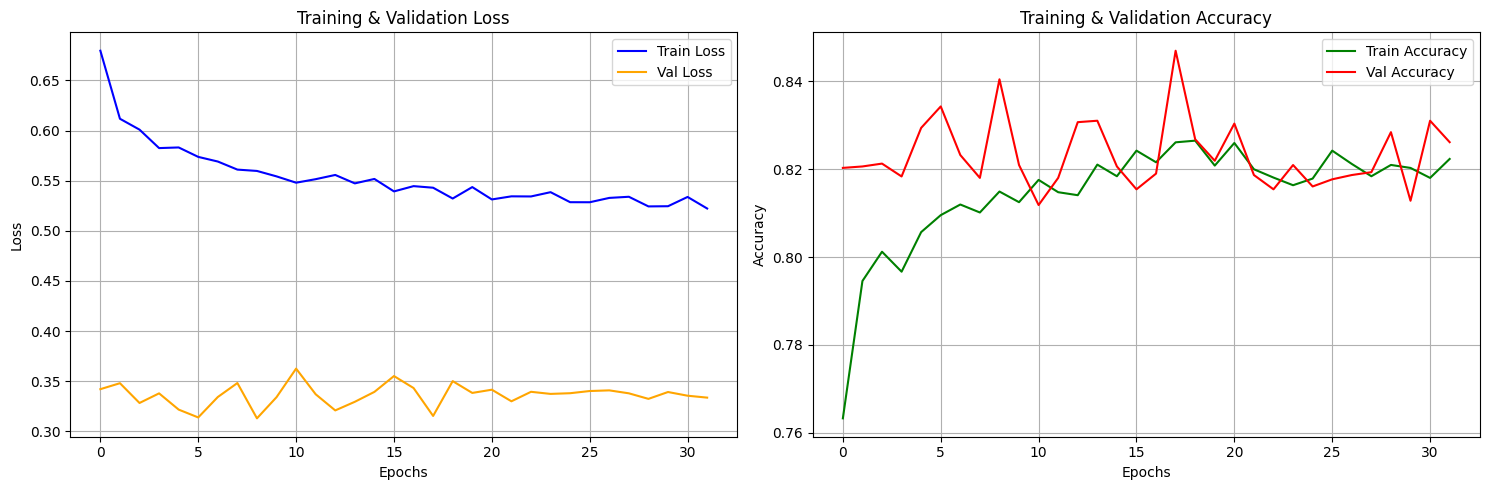

In [98]:
# -----------------------
# 9) Plot Training Curves
# -----------------------
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# --------- Loss subplot ---------
axs[0].plot(history_LSTM.history["loss"], label="Train Loss", color='blue')
axs[0].plot(history_LSTM.history["val_loss"], label="Val Loss", color='orange')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training & Validation Loss")
axs[0].legend()
axs[0].grid(True)

# --------- Accuracy subplot (if exists) ---------
axs[1].plot(history_LSTM.history["accuracy"], label="Train Accuracy", color='green')
axs[1].plot(history_LSTM.history["val_accuracy"], label="Val Accuracy", color='red')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training & Validation Accuracy")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Model Visualisation

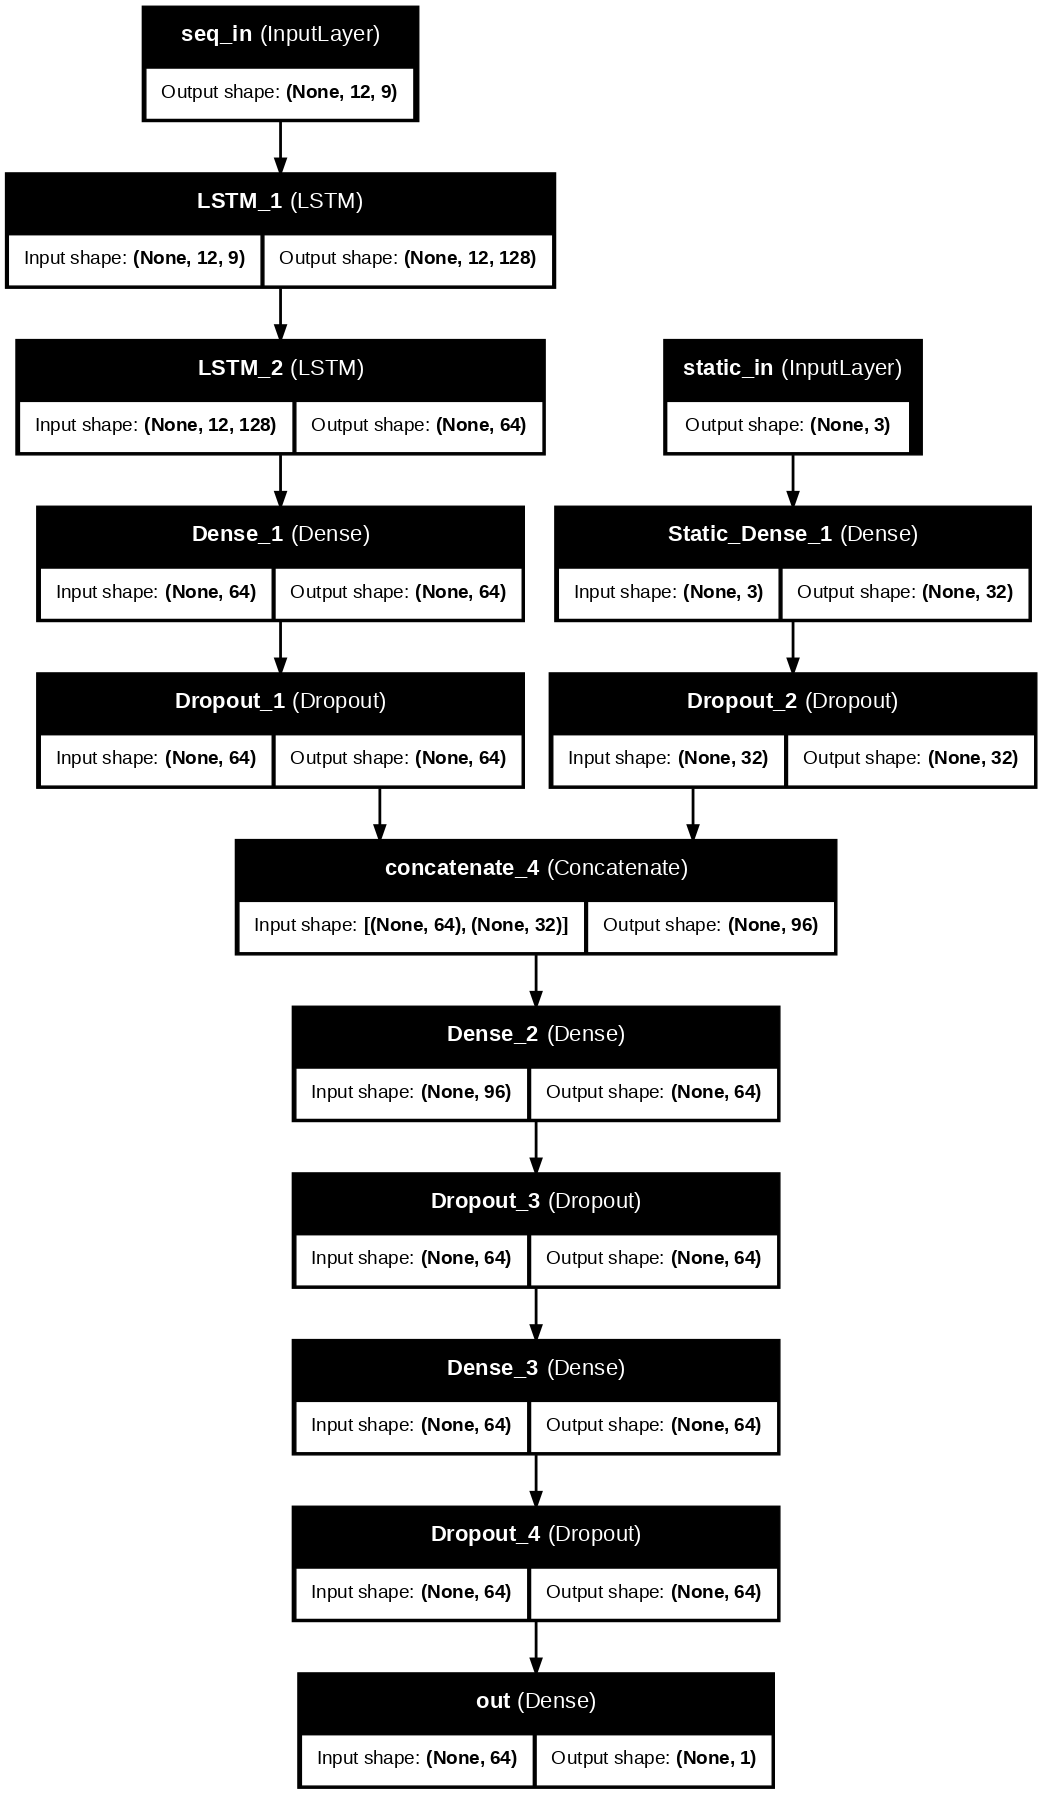

In [21]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(
    model,
    to_file="model_diagram.png",  # output file
    show_shapes=True,             # show tensor shapes
    show_layer_names=True,        # show layer names
    expand_nested=False,
    dpi=100
)


In [ ]:
model = make_model(
    n_steps=T,
    n_seq_feats=F,
    n_static_feats=Xs_tr_s.shape[1],
    lstm_units=(64, 32),
    dense_units=32,
    dropout=0.3,
    lr=1e-3
)
es = callbacks.EarlyStopping(
    monitor="val_accuracy", # Changed monitor to val_accuracy
    mode="max",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=[Xseq_tr_s, Xs_tr_s],
    y=y_train,
    validation_data=([Xseq_val_s, Xs_val_s], y_val),
    epochs=200,
    batch_size=128,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)

In [ ]:
param_grid = {
    'lstm_units': [(64, 32), (128, 64)],
    'dense_units': [32, 64],
    'dropout': [0.2, 0.3],
    'batch_size': [32, 64]
    }

In [ ]:
from itertools import product

best_score = -np.inf
best_params = None
best_model  = None

for lstm_units, dense_units, dropout, batch_size in product(
    param_grid['lstm_units'],
    param_grid['dense_units'],
    param_grid['dropout'],
    param_grid['batch_size']
):
    print(f"Training with: lstm={lstm_units}, dense={dense_units}, "
          f"dropout={dropout}, batch={batch_size}"
          )

    # 1) Build model
    model = make_model(
        n_steps=T,
        n_seq_feats=F,
        n_static_feats=Xs_tr_s.shape[1],
        lstm_units=lstm_units,
        dense_units=dense_units,
        dropout=dropout,
        optimizer='Adam',
        lr=1e-3,
        threshold=0.6
    )

    # 2) Early stopping
    es = callbacks.EarlyStopping(
        monitor='val_auc_pr',   # <-- use PR-AUC or Recall instead of accuracy
        mode="max",
        patience=10,
        restore_best_weights=True
    )

    # 3) Train
    history = model.fit(
        x=[Xseq_tr_s, Xs_tr_s],
        y=y_train,
        validation_data=([Xseq_val_s, Xs_val_s], y_val),
        epochs=100,
        batch_size=batch_size,
        class_weight=class_weight,
        callbacks=[es],
        verbose=0
    )

    # 4) Evaluate on validation set
    val_probs = model.predict([Xseq_val_s, Xs_val_s]).ravel()
    pr_auc = average_precision_score(y_val, val_probs)

    print(f"Validation PR-AUC = {pr_auc:.4f}")

    # 5) Save best
    if pr_auc > best_score:
        best_score = pr_auc
        best_params = (lstm_units, dense_units, dropout, lr, batch_size, optimizer)
        best_model = model


In [ ]:
print("Best params:", best_params)
print("Best PR-AUC:", best_score)


test_probs = best_model.predict([Xseq_te_s, Xs_te_s]).ravel()
test_pred  = (test_probs >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC:",  average_precision_score(y_test, test_probs))
print(classification_report(y_test, test_pred, digits=3))


In [26]:
Ntr, T, F = fXseq_tr_s.shape

model = make_model(
    n_steps=T,
    n_seq_feats=F,
    n_static_feats=fXs_tr_s.shape[1],
    lstm_units=(128, 64),
    dense_units=64,
    dropout=0.3,
    optimizer="Adam",
    lr=1e-3,
    threshold=0.5,
    alpha=0.01
)

neg = (fy_train == 0).sum()
pos = (fy_train == 1).sum()
pos_weight = neg / max(pos, 1)
class_weight = {0: 1.0, 1: float(pos_weight)}
print("Class weights:", class_weight)

Class weights: {0: 1.0, 1: 4.035066505441354}


In [27]:
es = callbacks.EarlyStopping(
    monitor="val_auc_pr", # Changed monitor to val_accuracy
    mode="max",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=[fXseq_tr_s, fXs_tr_s],
    y=fy_train,
    validation_data=([Xseq_te_s, Xs_te_s], y_test),
    epochs=100,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)

Epoch 1/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.7626 - auc_pr: 0.5350 - auc_roc: 0.8356 - loss: 0.7607 - precision: 0.4330 - recall: 0.7632 - val_accuracy: 0.7958 - val_auc_pr: 0.7039 - val_auc_roc: 0.8990 - val_loss: 0.3806 - val_precision: 0.5113 - val_recall: 0.8270
Epoch 2/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.7846 - auc_pr: 0.6512 - auc_roc: 0.9002 - loss: 0.6187 - precision: 0.4765 - recall: 0.9004 - val_accuracy: 0.7981 - val_auc_pr: 0.7220 - val_auc_roc: 0.9038 - val_loss: 0.3770 - val_precision: 0.5150 - val_recall: 0.8108
Epoch 3/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.7900 - auc_pr: 0.6594 - auc_roc: 0.9032 - loss: 0.6120 - precision: 0.4830 - recall: 0.8829 - val_accuracy: 0.8013 - val_auc_pr: 0.7257 - val_auc_roc: 0.9041 - val_loss: 0.3641 - val_precision: 0.5198 - val_recall: 0.8162
Epoch 4/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.7917 - auc_pr: 0.6854 - auc_roc: 0.9110 - loss: 0.5917 - p

In [29]:
test_probs = model.predict([Xseq_te_s, Xs_te_s]).ravel()
prec, rec, thr = precision_recall_curve(y_test, test_probs)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best threshold (F1 on val):", best_thr)

test_probs = model.predict([Xseq_te_s, Xs_te_s]).ravel()
test_pred  = (test_probs >= best_thr).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC:",  average_precision_score(y_test, test_probs))
print("Accuracy:", accuracy_score(y_test, test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Best threshold (F1 on val): 0.616315
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
ROC-AUC: 0.9151526162790697
PR-AUC: 0.7472593257703698
Accuracy: 0.8530927835051546
Confusion matrix:
 [[2427  325]
 [ 188  552]]
              precision    recall  f1-score   support

           0      0.928     0.882     0.904      2752
           1      0.629     0.746     0.683       740

    accuracy                          0.853      3492
   macro avg      0.779     0.814     0.794      3492
weighted avg      0.865     0.853     0.857      3492

